#### v4
- 변수 추가 (거래량 비율)

In [1]:
import pyodbc
import pandas as pd
import datetime
import numpy as np
import openpyxl as op
import xlwings as xw
import matplotlib.pyplot as plt
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
import joblib

In [4]:
import schedule

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.inspection import permutation_importance

In [6]:
conn_pcor = pyodbc.connect('driver={Oracle in OraClient18Home1};dbq=PCOR;uid=EF0SEL;pwd=EF0SEL#076')
conn_quant = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=quant;uid=index;pwd=samsung@00')
conn_wisefn = pyodbc.connect('driver={SQL Server};server=46.2.90.172;database=wisefn;uid=index;pwd=samsung@00')

####  초단위 데이터 JSON으로 저장

In [7]:
y_end = ['2011-12-31','2012-12-31','2013-12-31','2014-12-31','2015-12-31','2016-12-31','2017-12-31','2018-12-31',
         '2019-12-31','2020-12-31','2021-12-31','2022-12-31','2023-12-31']

In [5]:
f'KQ150_intraday_data_{int(y_end[0][:4])}.json'

'KQ150_intraday_data_2011.json'

for i in range(len(y_end)-1):
    
    sql = f'''
        SELECT *
        FROM KSC.KDQ150IDX
        WHERE BUCL_CD = '03'
        AND REG_D > '{y_end[i]}'
        AND REG_D <= '{y_end[i+1]}'
    '''
    
    df = pd.read_sql(sql, conn_pcor)
    
    f_name = f'KQ150_intraday_data_{int(y_end[i+1][:4])}.json'
    df.to_json(f_name)
    print(f'{int(y_end[i+1][:4])}Y data saved')

sql_daily = '''
    SELECT *
    FROM KSC.DKDQ150IDX
    WHERE BUCL_CD = '03'
    ORDER BY REG_D ASC
'''

df_daily = pd.read_sql(sql_daily,conn_pcor)
df_daily.to_json('KQ150_daily_data.json')

In [6]:
df_daily

NameError: name 'df_daily' is not defined

#### 데이터 시계열 정리

In [8]:
df_list = []
for i in range(2016,2024):
    df = pd.read_json(f'KQ150_intraday_data_{i}.json')
    
    df = df[df['REG_T']!='JUNJJJ']
    df = df[df['REG_T']!='PREJJJ']
    df = df[df['REG_T']!='EXTJJJ']
    
    dt = [datetime.datetime.fromtimestamp(x/1000) for x in df['REG_D']]
    df['Y'] = [x.year for x in dt]
    df['M'] = [x.month for x in dt]
    df['D'] = [x.day for x in dt]
    df['h'] = [int(y[:2]) for y in df['REG_T']]
    df['m'] = [int(y[2:4]) for y in df['REG_T']]
    df['s'] = [int(y[4:]) for y in df['REG_T']]
    df['TRD_DT'] = [datetime.date(x.year,x.month,x.day) for x in dt]
    df['TRD_DT_2'] = [datetime.datetime(x.year,x.month,x.day,int(y[:2]),int(y[2:4]),int(y[4:])).strftime("%Y-%m-%d %H:%M:%S")
                   for (x,y) in zip(dt,df['REG_T'])]
    
    df.drop_duplicates('TRD_DT_2', keep='last', inplace=True)
    
    df_2 = df[['TRD_DT','TRD_DT_2','Y','M','D','h','m','s','IDX','TR_CQ']]
    df_list.append(df_2)

In [9]:
df_daily = pd.read_json('KQ150_daily_data.json')
dt = [datetime.datetime.fromtimestamp(x/1000) for x in df_daily['REG_D']]
df_daily['TRD_DT'] = [datetime.date(x.year,x.month,x.day) for x in dt]

In [10]:
df_daily.dropna(subset = ['TR_P'], axis=0, inplace=True)

In [11]:
df = pd.concat(df_list,axis=0)
df.sort_values('TRD_DT_2',inplace=True)

In [12]:
df_mtick = df[df['s'] == 0]

In [13]:
df_mtick

,TRD_DT,TRD_DT_2,Y,M,D,h,m,s,IDX,TR_CQ
472,2016-05-11,2016-05-11 09:01:00,2016,5,11,9,1,0,1071.84,669
502,2016-05-11,2016-05-11 09:02:00,2016,5,11,9,2,0,1071.68,990
532,2016-05-11,2016-05-11 09:03:00,2016,5,11,9,3,0,1070.22,1236
562,2016-05-11,2016-05-11 09:04:00,2016,5,11,9,4,0,1069.93,1486
592,2016-05-11,2016-05-11 09:05:00,2016,5,11,9,5,0,1069.34,1737
...,...,...,...,...,...,...,...,...,...,...
5729597,2023-12-29,2023-12-29 15:26:00,2023,12,29,15,26,0,1390.82,82913
5729657,2023-12-29,2023-12-29 15:27:00,2023,12,29,15,27,0,1390.82,82913
5729717,2023-12-29,2023-12-29 15:28:00,2023,12,29,15,28,0,1390.82,82913
5729777,2023-12-29,2023-12-29 15:29:00,2023,12,29,15,29,0,1390.82,82913


#### Timestamp labeling

In [14]:
df_dt = df_daily['TRD_DT'].copy().to_frame()
df_dt

,TRD_DT
0,2016-05-11
1,2016-05-12
2,2016-05-13
5,2016-05-16
6,2016-05-17
...,...
2496,2024-01-10
2497,2024-01-11
2498,2024-01-12
2499,2024-01-15


In [15]:
df_mtick

,TRD_DT,TRD_DT_2,Y,M,D,h,m,s,IDX,TR_CQ
472,2016-05-11,2016-05-11 09:01:00,2016,5,11,9,1,0,1071.84,669
502,2016-05-11,2016-05-11 09:02:00,2016,5,11,9,2,0,1071.68,990
532,2016-05-11,2016-05-11 09:03:00,2016,5,11,9,3,0,1070.22,1236
562,2016-05-11,2016-05-11 09:04:00,2016,5,11,9,4,0,1069.93,1486
592,2016-05-11,2016-05-11 09:05:00,2016,5,11,9,5,0,1069.34,1737
...,...,...,...,...,...,...,...,...,...,...
5729597,2023-12-29,2023-12-29 15:26:00,2023,12,29,15,26,0,1390.82,82913
5729657,2023-12-29,2023-12-29 15:27:00,2023,12,29,15,27,0,1390.82,82913
5729717,2023-12-29,2023-12-29 15:28:00,2023,12,29,15,28,0,1390.82,82913
5729777,2023-12-29,2023-12-29 15:29:00,2023,12,29,15,29,0,1390.82,82913


In [16]:
df_dt['cls_prev'] = df_dt['TRD_DT'].shift(1)
fh_1 = []
slh_0 = []
rod_1 = []
lh_0 = []
lh_1 = []

for x in df_dt['TRD_DT']:
    
    temp = df_mtick[df_mtick['TRD_DT'] == x].copy()
    
    try:
        temp_fh = temp['TRD_DT_2'].iloc[29]
    except:
        temp_fh = "-"
    
    try:
        temp_lh0 = temp['TRD_DT_2'].iloc[-31]
    except:
        temp_lh0 = "-"
        
    try:
        temp_rod = temp['TRD_DT_2'].iloc[-32-1]
    except:
        temp_rod = "-"
        
    try:
        temp_slh = temp['TRD_DT_2'].iloc[-61]
    except:
        temp_slh = "-"
    
    try:
        temp_lh = temp['TRD_DT_2'].iloc[-1]
    except:
        temp_lh = "-"
    
    fh_1.append(temp_fh)
    slh_0.append(temp_slh)
    rod_1.append(temp_rod)
    lh_0.append(temp_lh0)
    lh_1.append(temp_lh)
    
df_dt['t_fh_1'] = fh_1
df_dt['t_slh_0'] = slh_0
df_dt['t_rod_1'] = rod_1
df_dt['t_lh_0'] = lh_0
df_dt['t_lh_1'] = lh_1

In [17]:
df_tlabel = df_dt[df_dt != "-"].dropna()

In [18]:
df_tlabel

,TRD_DT,cls_prev,t_fh_1,t_slh_0,t_rod_1,t_lh_0,t_lh_1
1,2016-05-12,2016-05-11,2016-05-12 09:30:00,2016-05-12 14:00:00,2016-05-12 14:28:00,2016-05-12 14:30:00,2016-05-12 15:00:00
2,2016-05-13,2016-05-12,2016-05-13 09:30:00,2016-05-13 14:00:00,2016-05-13 14:28:00,2016-05-13 14:30:00,2016-05-13 15:00:00
5,2016-05-16,2016-05-13,2016-05-16 09:30:00,2016-05-16 14:00:00,2016-05-16 14:28:00,2016-05-16 14:30:00,2016-05-16 15:00:00
6,2016-05-17,2016-05-16,2016-05-17 09:30:00,2016-05-17 14:00:00,2016-05-17 14:28:00,2016-05-17 14:30:00,2016-05-17 15:00:00
7,2016-05-18,2016-05-17,2016-05-18 09:30:00,2016-05-18 14:00:00,2016-05-18 14:28:00,2016-05-18 14:30:00,2016-05-18 15:00:00
...,...,...,...,...,...,...,...
2485,2023-12-21,2023-12-20,2023-12-21 09:30:00,2023-12-21 14:30:00,2023-12-21 14:58:00,2023-12-21 15:00:00,2023-12-21 15:30:00
2486,2023-12-22,2023-12-21,2023-12-22 09:30:00,2023-12-22 14:30:00,2023-12-22 14:58:00,2023-12-22 15:00:00,2023-12-22 15:30:00
2487,2023-12-26,2023-12-22,2023-12-26 09:30:00,2023-12-26 13:59:00,2023-12-26 14:27:00,2023-12-26 14:29:00,2023-12-26 14:59:00
2488,2023-12-27,2023-12-26,2023-12-27 09:30:00,2023-12-27 14:30:00,2023-12-27 14:58:00,2023-12-27 15:00:00,2023-12-27 15:30:00


In [19]:
df_plabel = df_tlabel.copy()

c_name = [x[2:] for x in df_tlabel.columns[2:]]

df_plabel = df_plabel.merge(df_daily[['TRD_DT','CLSIDX']], how = 'left', left_on = 'TRD_DT', right_on = 'TRD_DT')

temp = df_daily[['TRD_DT','CLSIDX']]
temp.columns = ['cls_prev','p_cls_prev']
df_plabel = df_plabel.merge(temp, how = 'left', left_on = 'cls_prev', right_on = 'cls_prev')

c_name_2 = ['TRD_DT','CLSIDX','p_cls_prev']
for c in c_name:
    
    temp = df_mtick[['TRD_DT_2','IDX']]
    temp.columns = ['TRD_DT_2',f'p_{c}']
    
    df_plabel = df_plabel.merge(temp, how = 'left', left_on = f't_{c}', right_on = ['TRD_DT_2'])
    c_name_2.append(f'p_{c}')

df_plabel = df_plabel[c_name_2]

In [20]:
df_vlabel = df_tlabel.copy()

c_name = [x[2:] for x in df_tlabel.columns[2:]]

df_vlabel = df_vlabel.merge(df_daily[['TRD_DT','TR_CQ']], how = 'left', left_on = 'TRD_DT', right_on = 'TRD_DT')

temp = df_daily[['TRD_DT','TR_CQ']]
temp.columns = ['cls_prev','v_cls_prev']
df_vlabel = df_vlabel.merge(temp, how = 'left', left_on = 'cls_prev', right_on = 'cls_prev')

c_name_2 = ['TRD_DT','TR_CQ','v_cls_prev']
for c in c_name:
    
    temp = df_mtick[['TRD_DT_2','TR_CQ']]
    temp.columns = ['TRD_DT_2',f'v_{c}']
    
    df_vlabel = df_vlabel.merge(temp, how = 'left', left_on = f't_{c}', right_on = ['TRD_DT_2'])
    c_name_2.append(f'v_{c}')

df_vlabel = df_vlabel[c_name_2]

In [21]:
df_plabel

,TRD_DT,CLSIDX,p_cls_prev,p_fh_1,p_slh_0,p_rod_1,p_lh_0,p_lh_1
0,2016-05-12,1073.07,1070.05,1066.17,1072.49,1073.01,1073.01,1073.14
1,2016-05-13,1070.22,1073.07,1068.69,1068.61,1069.13,1069.37,1070.35
2,2016-05-16,1065.96,1070.22,1069.00,1066.61,1065.97,1065.65,1066.61
3,2016-05-17,1056.03,1065.96,1058.32,1055.95,1056.21,1056.27,1056.44
4,2016-05-18,1034.60,1056.03,1045.16,1036.34,1036.87,1037.17,1035.28
...,...,...,...,...,...,...,...,...
1873,2023-12-21,1387.48,1395.37,1397.94,1388.07,1388.40,1392.14,1394.83
1874,2023-12-22,1369.78,1387.48,1389.01,1379.27,1372.50,1387.40,1387.56
1875,2023-12-26,1357.08,1369.78,1358.08,1356.63,1358.02,1357.98,1358.29
1876,2023-12-27,1384.38,1357.08,1380.04,1383.21,1383.65,1357.82,1356.84


In [22]:
df_vlabel

,TRD_DT,TR_CQ,v_cls_prev,v_fh_1,v_slh_0,v_rod_1,v_lh_0,v_lh_1
0,2016-05-12,30908.0,34710.0,4879,25274,27622,27784,29986
1,2016-05-13,32208.0,30908.0,5914,26275,28606,28782,31235
2,2016-05-16,33418.0,32208.0,6003,27377,29886,30083,32369
3,2016-05-17,50379.0,33418.0,12433,42800,45710,46048,49064
4,2016-05-18,46851.0,50379.0,7433,39195,42295,42524,45548
...,...,...,...,...,...,...,...,...
1873,2023-12-21,120741.0,147251.0,24936,106227,112110,139957,145440
1874,2023-12-22,98949.0,120741.0,23624,84026,89821,112554,118996
1875,2023-12-26,92323.0,98949.0,24875,73282,77789,78160,84305
1876,2023-12-27,114782.0,92323.0,25726,102763,108508,84554,90341


In [23]:
df_plabel['r_fh'] = df_plabel['p_fh_1']/df_plabel['p_cls_prev'] - 1
df_plabel['r_rod'] = df_plabel['p_rod_1']/df_plabel['p_cls_prev'] - 1
df_plabel['r_slh'] = df_plabel['p_rod_1']/df_plabel['p_slh_0'] - 1
df_plabel['r_lh'] = df_plabel['p_lh_1']/df_plabel['p_lh_0'] - 1
df_plabel['r_mh'] = df_plabel['p_slh_0']/df_plabel['p_fh_1'] - 1

In [24]:
df_vlabel['v_fh'] = df_vlabel['v_fh_1']
df_vlabel['v_rod'] = df_vlabel['v_rod_1']
df_vlabel['v_slh'] = df_vlabel['v_rod_1'] - df_vlabel['v_slh_0']
df_vlabel['v_lh'] = df_vlabel['v_lh_1'] - df_vlabel['v_lh_0']
df_vlabel['v_mh'] = df_vlabel['v_slh_0'] - df_vlabel['v_fh_1']

In [25]:
df_vlabel['v_fh_rod'] = df_vlabel['v_fh']/df_vlabel['v_rod']
df_vlabel['v_slh_rod'] = df_vlabel['v_slh']/df_vlabel['v_rod']
df_vlabel['v_mh_rod'] = df_vlabel['v_mh']/df_vlabel['v_rod']

In [26]:
df_plabel

,TRD_DT,CLSIDX,p_cls_prev,p_fh_1,p_slh_0,p_rod_1,p_lh_0,p_lh_1,r_fh,r_rod,r_slh,r_lh,r_mh
0,2016-05-12,1073.07,1070.05,1066.17,1072.49,1073.01,1073.01,1073.14,-0.003626,0.002766,0.000485,0.000121,0.005928
1,2016-05-13,1070.22,1073.07,1068.69,1068.61,1069.13,1069.37,1070.35,-0.004082,-0.003672,0.000487,0.000916,-0.000075
2,2016-05-16,1065.96,1070.22,1069.00,1066.61,1065.97,1065.65,1066.61,-0.001140,-0.003971,-0.000600,0.000901,-0.002236
3,2016-05-17,1056.03,1065.96,1058.32,1055.95,1056.21,1056.27,1056.44,-0.007167,-0.009147,0.000246,0.000161,-0.002239
4,2016-05-18,1034.60,1056.03,1045.16,1036.34,1036.87,1037.17,1035.28,-0.010293,-0.018143,0.000511,-0.001822,-0.008439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,2023-12-21,1387.48,1395.37,1397.94,1388.07,1388.40,1392.14,1394.83,0.001842,-0.004995,0.000238,0.001932,-0.007060
1874,2023-12-22,1369.78,1387.48,1389.01,1379.27,1372.50,1387.40,1387.56,0.001103,-0.010797,-0.004908,0.000115,-0.007012
1875,2023-12-26,1357.08,1369.78,1358.08,1356.63,1358.02,1357.98,1358.29,-0.008542,-0.008585,0.001025,0.000228,-0.001068
1876,2023-12-27,1384.38,1357.08,1380.04,1383.21,1383.65,1357.82,1356.84,0.016919,0.019579,0.000318,-0.000722,0.002297


In [27]:
df_vlabel

,TRD_DT,TR_CQ,v_cls_prev,v_fh_1,v_slh_0,v_rod_1,v_lh_0,v_lh_1,v_fh,v_rod,v_slh,v_lh,v_mh,v_fh_rod,v_slh_rod,v_mh_rod
0,2016-05-12,30908.0,34710.0,4879,25274,27622,27784,29986,4879,27622,2348,2202,20395,0.176635,0.085005,0.738361
1,2016-05-13,32208.0,30908.0,5914,26275,28606,28782,31235,5914,28606,2331,2453,20361,0.206740,0.081486,0.711774
2,2016-05-16,33418.0,32208.0,6003,27377,29886,30083,32369,6003,29886,2509,2286,21374,0.200863,0.083952,0.715184
3,2016-05-17,50379.0,33418.0,12433,42800,45710,46048,49064,12433,45710,2910,3016,30367,0.271997,0.063662,0.664340
4,2016-05-18,46851.0,50379.0,7433,39195,42295,42524,45548,7433,42295,3100,3024,31762,0.175742,0.073295,0.750963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1873,2023-12-21,120741.0,147251.0,24936,106227,112110,139957,145440,24936,112110,5883,5483,81291,0.222424,0.052475,0.725100
1874,2023-12-22,98949.0,120741.0,23624,84026,89821,112554,118996,23624,89821,5795,6442,60402,0.263012,0.064517,0.672471
1875,2023-12-26,92323.0,98949.0,24875,73282,77789,78160,84305,24875,77789,4507,6145,48407,0.319775,0.057939,0.622286
1876,2023-12-27,114782.0,92323.0,25726,102763,108508,84554,90341,25726,108508,5745,5787,77037,0.237089,0.052945,0.709966


In [28]:
for i in [1,5,20]:
    for c in ['v_fh','v_rod','v_slh','v_lh','v_mh','v_fh_rod','v_slh_rod','v_mh_rod']:
        df_vlabel[f'{c}_{i}d'] = df_vlabel[f'{c}']/(df_vlabel[f'{c}'].rolling(i).mean().shift(1))

In [29]:
df_vlabel_2 = df_vlabel.dropna(axis=0).reset_index(drop=True)
df_vlabel_2.set_index('TRD_DT', inplace=True)

In [30]:
df_plabel_2 = df_plabel.copy()
df_plabel_2.set_index('TRD_DT', inplace=True)
df_plabel_2 = df_plabel_2.loc[df_vlabel_2.index]

In [31]:
df_vlabel_2

,TR_CQ,v_cls_prev,v_fh_1,v_slh_0,v_rod_1,v_lh_0,v_lh_1,v_fh,v_rod,v_slh,...,v_slh_rod_5d,v_mh_rod_5d,v_fh_20d,v_rod_20d,v_slh_20d,v_lh_20d,v_mh_20d,v_fh_rod_20d,v_slh_rod_20d,v_mh_rod_20d
TRD_DT,,,,,,,,,,,,,,,,,,,,,
2016-06-10,38670.0,56781.0,6946,29832,33171,33394,37323,6946,33171,3339,...,1.130513,0.969017,0.817571,0.858373,1.100364,1.182614,0.844075,0.969106,1.276191,0.978570
2016-06-13,38010.0,38670.0,7470,30277,33069,33234,36795,7470,33069,2792,...,0.926523,0.977077,0.868680,0.849633,0.905318,1.044695,0.837315,1.037563,1.059897,0.981570
2016-06-14,33044.0,38010.0,5277,26889,29097,29275,31940,5277,29097,2208,...,0.816258,1.065615,0.608156,0.743320,0.710642,0.769331,0.789896,0.829369,0.950864,1.058777
2016-06-15,33972.0,33044.0,5615,28008,30253,30456,32898,5615,30253,2245,...,0.810276,1.052510,0.649828,0.773631,0.726067,0.701120,0.818085,0.852573,0.934580,1.053050
2016-06-16,48822.0,33972.0,6370,38991,43006,43295,47108,6370,43006,4015,...,0.999975,1.081274,0.767484,1.121924,1.312628,1.103842,1.209361,0.694168,1.168021,1.073338
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,120741.0,147251.0,24936,106227,112110,139957,145440,24936,112110,5883,...,0.601424,1.086321,0.986273,1.080868,0.720607,0.724713,1.156753,0.917999,0.668782,1.067512
2023-12-22,98949.0,120741.0,23624,84026,89821,112554,118996,23624,89821,5795,...,0.766715,0.995058,0.904398,0.842702,0.705322,0.835414,0.836020,1.069330,0.841460,0.992771
2023-12-26,92323.0,98949.0,24875,73282,77789,78160,84305,24875,77789,4507,...,0.964471,0.896354,0.926229,0.715323,0.541479,0.783616,0.657999,1.281463,0.762475,0.922626


In [32]:
df_plabel_2

,CLSIDX,p_cls_prev,p_fh_1,p_slh_0,p_rod_1,p_lh_0,p_lh_1,r_fh,r_rod,r_slh,r_lh,r_mh
TRD_DT,,,,,,,,,,,,
2016-06-10,1081.16,1083.29,1076.77,1077.07,1079.30,1079.28,1081.67,-0.006019,-0.003683,0.002070,0.002214,0.000279
2016-06-13,1059.12,1081.16,1066.13,1062.58,1061.08,1060.89,1060.92,-0.013902,-0.018573,-0.001412,0.000028,-0.003330
2016-06-14,1055.06,1059.12,1057.98,1054.82,1055.62,1056.02,1055.98,-0.001076,-0.003305,0.000758,-0.000038,-0.002987
2016-06-15,1057.48,1055.06,1050.12,1058.40,1057.86,1058.03,1058.65,-0.004682,0.002654,-0.000510,0.000586,0.007885
2016-06-16,1035.60,1057.48,1059.04,1033.15,1036.43,1036.89,1037.27,0.001475,-0.019906,0.003175,0.000366,-0.024447
...,...,...,...,...,...,...,...,...,...,...,...,...
2023-12-21,1387.48,1395.37,1397.94,1388.07,1388.40,1392.14,1394.83,0.001842,-0.004995,0.000238,0.001932,-0.007060
2023-12-22,1369.78,1387.48,1389.01,1379.27,1372.50,1387.40,1387.56,0.001103,-0.010797,-0.004908,0.000115,-0.007012
2023-12-26,1357.08,1369.78,1358.08,1356.63,1358.02,1357.98,1358.29,-0.008542,-0.008585,0.001025,0.000228,-0.001068


In [33]:
X1 = df_plabel_2[['r_fh','r_rod','r_slh','r_mh']]

c_list = []
for i in [1,5,20]:
    for c in ['v_fh','v_rod','v_slh','v_mh','v_fh_rod','v_slh_rod','v_mh_rod']:
        c_list.append(f'{c}_{i}d')

X2 = df_vlabel_2[c_list]

X3 = df_vlabel_2[['v_fh_rod','v_slh_rod','v_mh_rod']]

X = pd.concat([X1,X2,X3], axis=1)

y_raw = df_plabel_2['r_lh'].to_frame()

In [34]:
X = X[np.isfinite(X).all(1)]
y_raw = y_raw.loc[X.index]


fee = 0.0001
slipage = 0.0001

hurdle = fee * 2+ slipage
y_raw['y_label'] = [1 if x > hurdle else -1 if x < -hurdle else 0 for x in y_raw['r_lh']]
y = y_raw['y_label'].copy().to_frame()

In [35]:
train_cut = 0.8
purge = 0.01

train_end = int(len(X)*train_cut)
test_beg = int(len(X)*(train_cut + purge))

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_test, y_test = X.iloc[train_end:], y.iloc[train_end:]

In [36]:
param_grid = {
    'bootstrap': [True],
    'max_depth': list(range(2,11)),
    'max_features': list(range(2,11)),
    'n_estimators': list(range(5,31))
    }

In [37]:
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 4, n_jobs = 1, verbose = 0)

In [38]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'bootstrap': [True],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                          16, 17, 18, 19, 20, 21, 22, 23, 24,
                                          25, 26, 27, 28, 29, 30]})

In [39]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 2, 'max_features': 8, 'n_estimators': 17}

In [40]:
rf = RandomForestClassifier(bootstrap = grid_search.best_params_['bootstrap'],
                           n_estimators = grid_search.best_params_['n_estimators'],
                           max_depth = grid_search.best_params_['max_depth'],
                           max_features = grid_search.best_params_['max_features'])
rf.fit(X_train,y_train)
predict1 = rf.predict(X_train)
print(f"accuracy for best esimated params: {accuracy_score(y_train,predict1)}")
#print(f"f1 score for best esimated params: {f1_score(y_train,predict1)}")

accuracy for best esimated params: 0.5595959595959596


In [41]:
predict2 = rf.predict(X_test)
print(f"accuracy for best esimated params: {accuracy_score(y_test,predict2)}")
#print(f"f1 score for best esimated params: {f1_score(y_test,predict2)}")

accuracy for best esimated params: 0.510752688172043


In [42]:
df_importance = pd.DataFrame(rf.feature_importances_, index = X.columns, columns = ['feature importance']).sort_values(by = 'feature importance', ascending = False)
df_importance

,feature importance
r_fh,0.248749
r_rod,0.192067
r_slh,0.119263
v_slh_rod_1d,0.114592
v_slh_rod_20d,0.063401
v_mh_20d,0.041801
v_slh_rod_5d,0.039446
v_fh_5d,0.025651
v_rod_5d,0.025477
r_mh,0.023548


In [43]:
perm_result = permutation_importance(rf, X_train, y_train, scoring = 'accuracy',
                            n_repeats=30,
                            random_state=0)

In [44]:
perm_importances = pd.DataFrame(perm_result.importances_mean, index=X.columns, columns = ['perm_importance']).sort_values(by = 'perm_importance', ascending = False)
perm_importances

,perm_importance
r_fh,0.029360
r_rod,0.015623
r_slh,0.008238
v_slh_rod_1d,0.003098
v_slh_rod_5d,0.002649
v_rod_5d,0.001886
v_slh_1d,0.001886
v_mh_rod,0.000831
v_mh_rod_20d,0.000831
v_slh_rod_20d,0.000808


In [47]:
importance_hurdle = 1/len(df_importance)
importance_mid = df_importance[(df_importance > importance_hurdle)].dropna(axis=0).index

importance_perm = perm_importances[perm_importances > 0].dropna(axis=0).index

important_feature = list(set(importance_perm).intersection(set(importance_mid)))
important_feature

['r_fh', 'v_slh_rod_1d', 'v_slh_rod_20d', 'v_slh_rod_5d', 'r_slh', 'r_rod']

In [46]:
importance_mid = df_importance[(df_importance > 0)].dropna(axis=0).index

importance_perm = perm_importances[perm_importances > 0].dropna(axis=0).index

important_feature = list(set(importance_perm).intersection(set(importance_mid)))
important_feature

['v_slh_rod',
 'v_mh_rod',
 'r_fh',
 'v_mh_rod_20d',
 'v_fh_rod_20d',
 'v_slh_rod_1d',
 'v_slh_1d',
 'v_slh_rod_20d',
 'v_slh_rod_5d',
 'v_fh_rod_1d',
 'r_slh',
 'r_rod',
 'v_rod_5d',
 'r_mh',
 'v_mh_rod_5d']

In [48]:
temp1 = y_test
temp2 = pd.DataFrame(predict2, index = temp1.index, columns = ['pred'])
temp = pd.concat([temp1,temp2],axis=1)
temp

,y_label,pred
TRD_DT,,
2022-06-29,1,-1
2022-06-30,-1,-1
2022-07-01,-1,1
2022-07-04,1,1
2022-07-05,1,1
...,...,...
2023-12-21,1,1
2023-12-22,0,1
2023-12-26,0,1


In [49]:
backtest_df = y_raw.copy()
backtest_df = backtest_df.loc[temp.index]
backtest_df['r_lh'] = backtest_df['r_lh'] - hurdle
backtest_df = pd.concat([backtest_df, temp[['pred']]], axis=1)
backtest_df['ret'] = [backtest_df['r_lh'].iloc[x] if backtest_df['pred'].iloc[x] == 1 else 
                      -backtest_df['r_lh'].iloc[x] if backtest_df['pred'].iloc[x] == -1 else 
                      0 for x in range(len(backtest_df))]

In [50]:
backtest_df

,r_lh,y_label,pred,ret
TRD_DT,,,,
2022-06-29,0.001934,1,-1,-0.001934
2022-06-30,-0.003369,-1,-1,0.003369
2022-07-01,-0.001188,-1,1,-0.001188
2022-07-04,0.005750,1,1,0.005750
2022-07-05,0.002420,1,1,0.002420
...,...,...,...,...
2023-12-21,0.001632,1,1,0.001632
2023-12-22,-0.000185,0,1,-0.000185
2023-12-26,-0.000072,0,1,-0.000072


In [51]:
(backtest_df['ret'] + 1).cumprod()

TRD_DT
2022-06-29    0.998066
2022-06-30    1.001428
2022-07-01    1.000238
2022-07-04    1.005990
2022-07-05    1.008424
                ...   
2023-12-21    1.060287
2023-12-22    1.060091
2023-12-26    1.060015
2023-12-27    1.058932
2023-12-28    1.058943
Name: ret, Length: 372, dtype: float64

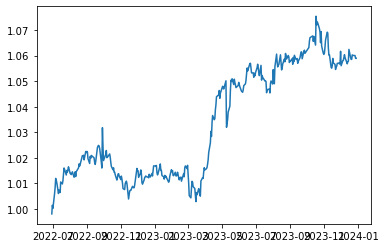

In [52]:
plt.plot(df_plabel_2.loc[backtest_df.index].index,(backtest_df['ret'] + 1).cumprod())

#### train,test 기간 전체

In [53]:
temp1 = pd.DataFrame(predict1, index = y_train.index, columns = ['pred'])
temp2 = pd.DataFrame(predict2, index = y_test.index, columns = ['pred'])
temp = pd.concat([temp1,temp2],axis=0)
temp

,pred
TRD_DT,
2016-06-10,1
2016-06-13,-1
2016-06-14,1
2016-06-15,1
2016-06-16,1
...,...
2023-12-21,1
2023-12-22,1
2023-12-26,1


In [54]:
backtest_df = y_raw.copy()
backtest_df['r_lh'] = backtest_df['r_lh'] - hurdle
backtest_df = pd.concat([backtest_df, temp[['pred']]], axis=1)
backtest_df['ret'] = [backtest_df['r_lh'].iloc[x] if backtest_df['pred'].iloc[x] == 1 else 
                      -backtest_df['r_lh'].iloc[x] if backtest_df['pred'].iloc[x] == -1 else 
                      0 for x in range(len(backtest_df))]

In [55]:
(backtest_df['ret'] + 1).cumprod()

TRD_DT
2016-06-10    1.001914
2016-06-13    1.002187
2016-06-14    1.001848
2016-06-15    1.002135
2016-06-16    1.002201
                ...   
2023-12-21    2.245030
2023-12-22    2.244615
2023-12-26    2.244455
2023-12-27    2.242161
2023-12-28    2.242186
Name: ret, Length: 1857, dtype: float64

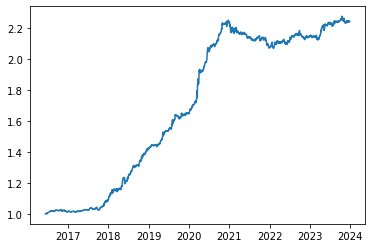

In [56]:
plt.plot(df_plabel_2.loc[backtest_df.index].index, (backtest_df['ret'] + 1).cumprod())

In [57]:
(backtest_df['ret'] + 1).cumprod().iloc[-1] **(252/(len(backtest_df)-1))

1.1158677720693113

#### 중요도 높은 Feature만 쓰기

In [58]:
X1 = df_plabel_2[['r_fh','r_rod','r_slh','r_mh']]

c_list = []
for i in [1,5,20]:
    for c in ['v_fh','v_rod','v_slh','v_mh','v_fh_rod','v_slh_rod','v_mh_rod']:
        c_list.append(f'{c}_{i}d')

X2 = df_vlabel_2[c_list]

X3 = df_vlabel_2[['v_fh_rod','v_slh_rod','v_mh_rod']]

X = pd.concat([X1,X2,X3], axis=1)
X = X[important_feature]

y_raw = df_plabel_2['r_lh'].to_frame()

In [59]:
X = X[np.isfinite(X).all(1)]
y_raw = y_raw.loc[X.index]


fee = 0.0001
slipage = 0.0001

hurdle = fee * 2+ slipage
y_raw['y_label'] = [1 if x > hurdle else -1 if x < -hurdle else 0 for x in y_raw['r_lh']]
y = y_raw['y_label'].copy().to_frame()

In [60]:
X.corr()

,r_fh,v_slh_rod_1d,v_slh_rod_20d,v_slh_rod_5d,r_slh,r_rod
r_fh,1.000000,-0.021941,-0.028912,-0.042519,-0.089095,0.653448
v_slh_rod_1d,-0.021941,1.000000,0.690085,0.387112,0.029450,-0.034495
v_slh_rod_20d,-0.028912,0.690085,1.000000,0.426579,0.026081,-0.049889
v_slh_rod_5d,-0.042519,0.387112,0.426579,1.000000,-0.005251,-0.054320
r_slh,-0.089095,0.029450,0.026081,-0.005251,1.000000,0.282947
r_rod,0.653448,-0.034495,-0.049889,-0.054320,0.282947,1.000000


In [61]:
train_cut = 0.8
purge = 0.01

train_end = int(len(X)*train_cut)
test_beg = int(len(X)*(train_cut + purge))

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_test, y_test = X.iloc[train_end:], y.iloc[train_end:]

In [62]:
param_grid = {
    'bootstrap': [True],
    'max_depth': list(range(2,11)),
    'max_features': [2, 3, 4, 5 ,6],
    'n_estimators': list(range(5,31))
    }

In [63]:
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 4, n_jobs = 1, verbose = 0)

In [64]:
grid_search.fit(X_train, y_train)

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=1,
             param_grid={'bootstrap': [True],
                         'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'max_features': [2, 3, 4, 5, 6],
                         'n_estimators': [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15,
                                          16, 17, 18, 19, 20, 21, 22, 23, 24,
                                          25, 26, 27, 28, 29, 30]})

In [65]:
grid_search.best_params_

{'bootstrap': True, 'max_depth': 2, 'max_features': 4, 'n_estimators': 27}

In [66]:
rf = RandomForestClassifier(bootstrap = grid_search.best_params_['bootstrap'],
                           n_estimators = grid_search.best_params_['n_estimators'],
                           max_depth = grid_search.best_params_['max_depth'],
                           max_features = grid_search.best_params_['max_features'])
rf.fit(X_train,y_train)
predict1 = rf.predict(X_train)
print(f"accuracy for best esimated params: {accuracy_score(y_train,predict1)}")
#print(f"f1 score for best esimated params: {f1_score(y_train,predict1)}")

accuracy for best esimated params: 0.553835800807537


In [67]:
predict2 = rf.predict(X_test)
print(f"accuracy for best esimated params: {accuracy_score(y_test,predict2)}")
#print(f"f1 score for best esimated params: {f1_score(y_test,predict2)}")

accuracy for best esimated params: 0.5188172043010753


In [68]:
df_importance = pd.DataFrame(rf.feature_importances_, index = X.columns, columns = ['feature importance']).sort_values(by = 'feature importance', ascending = False)
df_importance

,feature importance
r_rod,0.510163
r_fh,0.221185
r_slh,0.124247
v_slh_rod_1d,0.069408
v_slh_rod_20d,0.050675
v_slh_rod_5d,0.024323


In [69]:
perm_result = permutation_importance(rf, X_train, y_train, scoring = 'accuracy',
                            n_repeats=30,
                            random_state=0)

In [70]:
perm_importances = pd.DataFrame(perm_result.importances_mean, index=X.columns, columns = ['perm_importance']).sort_values(by = 'perm_importance', ascending = False)
perm_importances

,perm_importance
r_rod,0.066218
r_fh,0.007290
v_slh_rod_20d,0.002064
r_slh,0.000404
v_slh_rod_5d,-0.000202
v_slh_rod_1d,-0.001301


In [71]:
df_importance.sum()

feature importance    1.0
dtype: float64

In [72]:
temp1 = y_test
temp2 = pd.DataFrame(predict2, index = temp1.index, columns = ['pred'])
temp = pd.concat([temp1,temp2],axis=1)
temp

,y_label,pred
TRD_DT,,
2022-06-29,1,-1
2022-06-30,-1,-1
2022-07-01,-1,-1
2022-07-04,1,1
2022-07-05,1,1
...,...,...
2023-12-21,1,1
2023-12-22,0,1
2023-12-26,0,1


In [73]:
backtest_df = y_raw.copy()
backtest_df = backtest_df.loc[temp.index]
backtest_df['r_lh'] = backtest_df['r_lh'] - hurdle
backtest_df = pd.concat([backtest_df, temp[['pred']]], axis=1)
backtest_df['ret'] = [backtest_df['r_lh'].iloc[x] if backtest_df['pred'].iloc[x] == 1 else 
                      -backtest_df['r_lh'].iloc[x] if backtest_df['pred'].iloc[x] == -1 else 
                      0 for x in range(len(backtest_df))]

In [74]:
backtest_df

,r_lh,y_label,pred,ret
TRD_DT,,,,
2022-06-29,0.001934,1,-1,-0.001934
2022-06-30,-0.003369,-1,-1,0.003369
2022-07-01,-0.001188,-1,-1,0.001188
2022-07-04,0.005750,1,1,0.005750
2022-07-05,0.002420,1,1,0.002420
...,...,...,...,...
2023-12-21,0.001632,1,1,0.001632
2023-12-22,-0.000185,0,1,-0.000185
2023-12-26,-0.000072,0,1,-0.000072


In [75]:
(backtest_df['ret'] + 1).cumprod()

TRD_DT
2022-06-29    0.998066
2022-06-30    1.001428
2022-07-01    1.002618
2022-07-04    1.008384
2022-07-05    1.010824
                ...   
2023-12-21    1.044840
2023-12-22    1.044647
2023-12-26    1.044573
2023-12-27    1.043505
2023-12-28    1.043517
Name: ret, Length: 372, dtype: float64

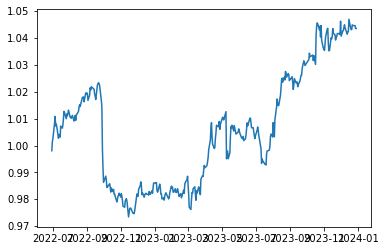

In [76]:
plt.plot(df_plabel_2.loc[backtest_df.index].index,(backtest_df['ret'] + 1).cumprod())

#### train,test 기간 전체

In [77]:
temp1 = pd.DataFrame(predict1, index = y_train.index, columns = ['pred'])
temp2 = pd.DataFrame(predict2, index = y_test.index, columns = ['pred'])
temp = pd.concat([temp1,temp2],axis=0)
temp

,pred
TRD_DT,
2016-06-10,1
2016-06-13,-1
2016-06-14,1
2016-06-15,1
2016-06-16,-1
...,...
2023-12-21,1
2023-12-22,1
2023-12-26,1


In [78]:
backtest_df = y_raw.copy()
backtest_df['r_lh'] = backtest_df['r_lh'] - hurdle
backtest_df = pd.concat([backtest_df, temp[['pred']]], axis=1)
backtest_df['ret'] = [backtest_df['r_lh'].iloc[x] if backtest_df['pred'].iloc[x] == 1 else 
                      -backtest_df['r_lh'].iloc[x] if backtest_df['pred'].iloc[x] == -1 else 
                      0 for x in range(len(backtest_df))]

In [79]:
(backtest_df['ret'] + 1).cumprod()

TRD_DT
2016-06-10    1.001914
2016-06-13    1.002187
2016-06-14    1.001848
2016-06-15    1.002135
2016-06-16    1.002068
                ...   
2023-12-21    2.216010
2023-12-22    2.215600
2023-12-26    2.215441
2023-12-27    2.213178
2023-12-28    2.213202
Name: ret, Length: 1858, dtype: float64

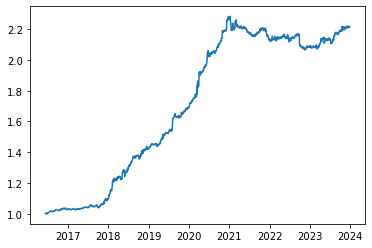

In [80]:
plt.plot(df_plabel_2.loc[backtest_df.index].index, (backtest_df['ret'] + 1).cumprod())

In [81]:
(backtest_df['ret'] + 1).cumprod().iloc[-1] **(252/(len(backtest_df)-1))

1.1138335642408768

In [82]:
rf

RandomForestClassifier(max_depth=2, max_features=4, n_estimators=27)

In [83]:
joblib.dump(rf, 'intraday_momentum_kq150_rf_v2.pkl')

['intraday_momentum_kq150_rf_v2.pkl']

#### Feature 압축

In [ ]:
X1 = df_plabel_2[['r_fh','r_rod','r_slh','r_mh']]

c_list = []
for i in [1,5,20]:
    for c in ['v_fh','v_rod','v_slh','v_mh']:
        c_list.append(f'{c}_{i}d')

X2 = df_vlabel_2[c_list]

X = pd.concat([X1,X2], axis=1)
X = X[important_feature_2]

y_raw = df_plabel_2['r_lh'].to_frame()

In [ ]:
X = X[np.isfinite(X).all(1)]
y_raw = y_raw.loc[X.index]


fee = 0.0001
slipage = 0.0001

hurdle = fee * 2+ slipage
y_raw['y_label'] = [1 if x > hurdle else -1 if x < -hurdle else 0 for x in y_raw['r_lh']]
y = y_raw['y_label'].copy().to_frame()

In [ ]:
train_cut = 0.8
purge = 0.01

train_end = int(len(X)*train_cut)
test_beg = int(len(X)*(train_cut + purge))

X_train, y_train = X.iloc[:train_end], y.iloc[:train_end]
X_test, y_test = X.iloc[train_end:], y.iloc[train_end:]

In [ ]:
param_grid = {
    'bootstrap': [True],
    'max_depth': list(range(2,11)),
    'max_features': [2, 3, 4,5],
    'n_estimators': list(range(5,31))
    }

In [ ]:
rf = RandomForestClassifier()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 4, n_jobs = 1, verbose = 0)

In [ ]:
grid_search.fit(X_train, y_train)

In [ ]:
grid_search.best_params_

In [ ]:
rf = RandomForestClassifier(bootstrap = grid_search.best_params_['bootstrap'],
                           n_estimators = grid_search.best_params_['n_estimators'],
                           max_depth = grid_search.best_params_['max_depth'],
                           max_features = grid_search.best_params_['max_features'])
rf.fit(X_train,y_train)
predict1 = rf.predict(X_train)
print(f"accuracy for best esimated params: {accuracy_score(y_train,predict1)}")
#print(f"f1 score for best esimated params: {f1_score(y_train,predict1)}")

In [ ]:
predict2 = rf.predict(X_test)
print(f"accuracy for best esimated params: {accuracy_score(y_test,predict2)}")

In [ ]:
df_importance = pd.DataFrame(rf.feature_importances_, index = X.columns, columns = ['feature importance']).sort_values(by = 'feature importance', ascending = False)
df_importance

In [ ]:
perm_result = permutation_importance(rf, X_train, y_train, scoring = 'accuracy',
                            n_repeats=30,
                            random_state=0)

In [ ]:
perm_importances = pd.DataFrame(perm_result.importances_mean, index=X.columns, columns = ['perm_importance']).sort_values(by = 'perm_importance', ascending = False)
perm_importances

In [ ]:
temp1 = y_test
temp2 = pd.DataFrame(predict2, index = temp1.index, columns = ['pred'])
temp = pd.concat([temp1,temp2],axis=1)
temp

In [ ]:
backtest_df = y_raw.copy()
backtest_df = backtest_df.loc[temp.index]
backtest_df['r_lh'] = backtest_df['r_lh'] - hurdle
backtest_df = pd.concat([backtest_df, temp[['pred']]], axis=1)
backtest_df['ret'] = [backtest_df['r_lh'].iloc[x] if backtest_df['pred'].iloc[x] == 1 else 
                      -backtest_df['r_lh'].iloc[x] if backtest_df['pred'].iloc[x] == -1 else 
                      0 for x in range(len(backtest_df))]

In [ ]:
(backtest_df['ret'] + 1).cumprod()

In [ ]:
plt.plot(df_plabel_2.loc[backtest_df.index]['TRD_DT'],(backtest_df['ret'] + 1).cumprod())

In [ ]:
temp1 = pd.DataFrame(predict1, index = y_train.index, columns = ['pred'])
temp2 = pd.DataFrame(predict2, index = y_test.index, columns = ['pred'])
temp = pd.concat([temp1,temp2],axis=0)
temp

In [ ]:
backtest_df = y_raw.copy()
backtest_df['r_lh'] = backtest_df['r_lh'] - hurdle
backtest_df = pd.concat([backtest_df, temp[['pred']]], axis=1)
backtest_df['ret'] = [backtest_df['r_lh'].iloc[x] if backtest_df['pred'].iloc[x] == 1 else 
                      -backtest_df['r_lh'].iloc[x] if backtest_df['pred'].iloc[x] == -1 else 
                      0 for x in range(len(backtest_df))]

In [ ]:
(backtest_df['ret'] + 1).cumprod()

In [ ]:
plt.plot(df_plabel_2.loc[backtest_df.index]['TRD_DT'], (backtest_df['ret'] + 1).cumprod())

In [ ]:
(backtest_df['ret'] + 1).cumprod().iloc[-1] **(252/(len(backtest_df)-1))